# Promoting financial products to bank customers 

In previous 4 years, a retail bank sold several products (mortgage account, savings account, and pension account) to its customers. It kept records of all historical data, and this data is available for analysis and reuse.
Following a merger in 2021, the bank has new customers and wants to launch some marketing campaigns. 

The budget for the campaigns is limited. The bank wants to contact a customer and propose only one product.


The marketing department needs to decide:
   * Who should be contacted?
   * Which product should be proposed? (Proposing too many products is counter productive, so only one product per customer contact will be proposed).
   * How will a customer be contacted? There are different ways, with different costs and efficiency.
   * How can they optimally use their limited budget?
   * Will such campaigns be profitable?
   
### Predictive and prescriptive workflow

From the historical data, you can train a machine learning product-based classifier on customer profile (age, income, account level, ...) to predict whether a customer would subscribe to a mortgage, savings, or pension account.
* I will apply this predictive model to the new customer data to predict for each new customer what they will buy.
* With this new data, I will decide which offers will be proposed. Which product will be offered to which customer through which channel will be determined with a greedy algorithm that reproduces what a human being would do. 
The solutions can be displayed, compared, and analyzed.

The purpose of this notebook is to show how easy it is to mix machine learning and greedy optimization algorithm by doing a forecast, then getting fast and reliable decisions on this new data. 

# Content

*  [Understand the historical data](#Understand-the-historical-data)
*  [Predict the 2021 customer behavior](#Predict-the-2021-customer-behavior)
*  [Get business decisions for the 2021 data. Greedy Optimization algorithm](#Get-business-decisions-for-the-2021-data.-Greedy-Optimization-algorithm),
*  [New customer clusterization](#New-customer-clasterization)
*  [Summary conclusion](#Summary-conclusion)

### How  decision optimization can help

Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

Prescriptive analytics takes that prediction to the next level by suggesting the optimal way to handle that future situation. Organizations gain a strong competitive advantage by acting quickly in dynamic conditions and making superior decisions in uncertain environments.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm

%matplotlib inline

# Understand the historical data
Load 2016-2020 historical data, analyze it visually, and train a classifier to predict 2021 sales.

##### Load the historical customer data with their purchases (Mortgage, Savings, and Pension).

In [2]:
known_behaviors = pd.read_csv("https://raw.githubusercontent.com/vberaudi/utwt/master/known_behaviors2.csv")
known_behaviors.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,...,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage,Pension,Savings
0,15,45,12,45,0,0,0,0,65,13453,...,0,4,2,1,14,19,7.602,0,0,0
1,16,43,12,43,0,0,0,0,65,13453,...,0,0,3,2,14,19,10.143,0,0,0
2,30,23,0,23,0,0,0,0,65,13453,...,0,1,0,0,14,19,0.000,0,0,0
3,42,35,8,35,1,0,0,0,65,13453,...,0,1,0,0,14,19,0.000,0,1,0
4,52,43,12,43,1,0,0,0,47,14124,...,3,1,0,0,16,35,0.000,0,1,0


#### Check the 2016-2020 customers

In [3]:
a = known_behaviors[known_behaviors.Mortgage == 1]
b = known_behaviors[known_behaviors.Pension == 1]
c = known_behaviors[known_behaviors.Savings == 1]
print("Number of clients: %d" %len(known_behaviors))
print("Number of clients predicted to buy mortgage accounts: %d" %len(a))
print("Number of clients predicted to buy pension accounts: %d" %len(b))
print("Number of clients predicted to buy savings accounts: %d" %len(c))

Number of clients: 11023
Number of clients predicted to buy mortgage accounts: 1664
Number of clients predicted to buy pension accounts: 2456
Number of clients predicted to buy savings accounts: 4222


In [4]:
known_behaviors["nb_products"] = known_behaviors.Mortgage + known_behaviors.Pension + known_behaviors.Savings

In [5]:
abc = known_behaviors[known_behaviors.nb_products > 1]
print("You have %d clients who bought several products" %len(abc))
abc = known_behaviors[known_behaviors.nb_products == 3]
print("You have %d clients who bought all the products" %len(abc))

You have 1650 clients who bought several products
You have 123 clients who bought all the products


In [6]:
products = ["Savings", "Mortgage", "Pension"]

##### Provide some visual analysis of the historical data

It's possible to use pandas plotting capabilities, but that would require a new version of it. This notebook relies on matplotlib as it is commonly used.

In [7]:
def plot_cloud_points(df):
    figure = plt.figure(figsize=(20, 5))
    my_cm  = ListedColormap(['#bb7d00', '#00c8ff'])
    axes = {p : ('age', 'income') if p != "Mortgage"else ('members_in_household', 'loan_accounts') for p in products}
    for product in products:
        ax = plt.subplot(1, len(products), products.index(product)+1)
        ax.set_title(product)
        axe = axes[product]
        plt.xlabel(axe[0])
        plt.ylabel(axe[1])
        ax.scatter(df[axe[0]], df[axe[1]], c=df[product], cmap=my_cm, alpha=0.5)

In the following visualization, you can see the behavior of the 2016-2020 customers for the three products.
The green color indicates that a customer bought a product; red indicates a customer did not buy a product.
The depth of the color indicates the number of purchases or non-purchases.

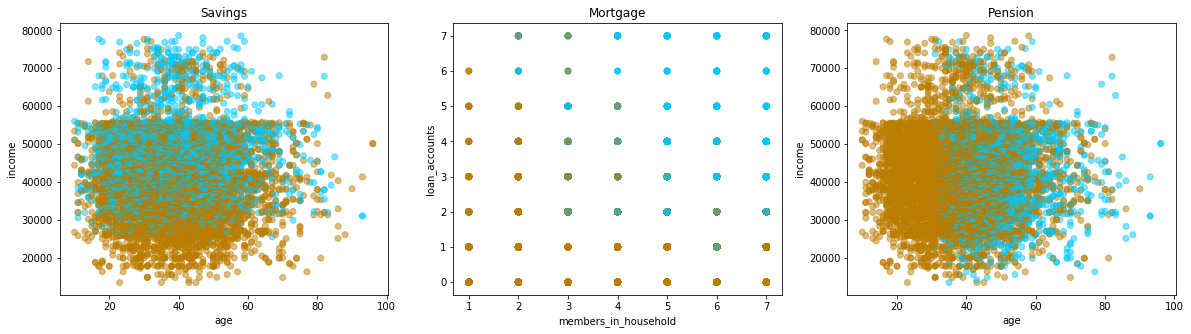

In [8]:
plot_cloud_points(known_behaviors)

### Understanding the 2016-2020 years customers
You can see that:
   * The greater a customer's income, the more likely it is he or she will buy a savings account.
   * The older a customer is, the more likely it is he or she will buy a pension account.
   * There is a correlation between the number of people in a customer's household, the number of loan accounts held by the customer, and the likelihood a customer buys a mortgage account. To see the correlation, look at the upper right and lower left corners of the mortgage chart.

# Predict the 2021 customer behavior
### Create and train a simple machine-learning algorithm to predict what the new clients will buy.

In [9]:
known_behaviors.columns

Index(['customer_id', 'age', 'age_youngest_child', 'debt_equity', 'gender',
       'bad_payment', 'gold_card', 'pension_plan',
       'household_debt_to_equity_ratio', 'income', 'members_in_household',
       'months_current_account', 'months_customer', 'call_center_contacts',
       'loan_accounts', 'number_products', 'number_transactions',
       'non_worker_percentage', 'white_collar_percentage', 'rfm_score',
       'Mortgage', 'Pension', 'Savings', 'nb_products'],
      dtype='object')

Use the following columns as machine-learning features:

In [10]:
cols = ['age', 'income', 'members_in_household', 'loan_accounts']

In [11]:
X = known_behaviors[cols]
ys = [known_behaviors[p] for p in products]

In [12]:
X.head()

,age,income,members_in_household,loan_accounts
0,45,13453,2,4
1,43,13453,2,0
2,23,13453,2,1
3,35,13453,2,1
4,43,14124,3,1


You are using a standard basic support gradient boosting algorithm to predict whether a customer might by product A, B, or C.

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

### Cross-validation & training

In [14]:
scaler = preprocessing.RobustScaler().fit(X)
X_train_transformed = scaler.transform(X)
classifiers = []
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
for i,p in enumerate(products):
    clf = XGBClassifier()
    scores = cross_val_score(clf, X_train_transformed, ys[i], cv=cv, scoring='f1_macro')
    print("Product {}: Cross-validation F1-scores: {}".format(p, scores))
    clf.fit(X, ys[i])
    classifiers.append(clf)

Product Savings: Cross-validation F1-scores: [0.56139858 0.56076667 0.55868646 0.55475193 0.56928495]
Product Mortgage: Cross-validation F1-scores: [0.77289787 0.78564312 0.78627694 0.7911282  0.77420335]
Product Pension: Cross-validation F1-scores: [0.57086214 0.55215666 0.56485513 0.56732264 0.56478126]


### New customer data and predictions

Load new customer data, predict behaviors using a trained classifier, and perform some visual analysis.
You have all the characteristics of the new customers, as for the 2016-2020 clients, but the new customers have not yet bought any product.

##### Load new customer data

In [15]:
unknown_behaviors = pd.read_csv("https://raw.githubusercontent.com/vberaudi/utwt/master/unknown_behaviors.csv")

In [16]:
to_predict = unknown_behaviors[cols]

In [17]:
print("Number of new customers: %d" %len(unknown_behaviors))

Number of new customers: 2756


##### Predict behaviors of the new customers

In [18]:
predicted = [classifiers[i].predict(to_predict) for i in range(len(products))]
for i,p in enumerate(products):
    to_predict[p] = predicted[i]
to_predict["id"] = unknown_behaviors["customer_id"]


##### Package new data with predictions for optimization

In [19]:
offers = to_predict
offers
offers.head()

,age,income,members_in_household,loan_accounts,Savings,Mortgage,Pension,id
0,38,47958.0,4,1,1,0,0,44256
1,30,48606.0,2,4,0,0,0,46883
2,41,42152.0,4,0,0,0,0,32387
3,42,39788.0,3,3,0,0,0,25504
4,42,44365.0,6,2,0,1,0,35979


##### Perform some visual analysis of the predicted data

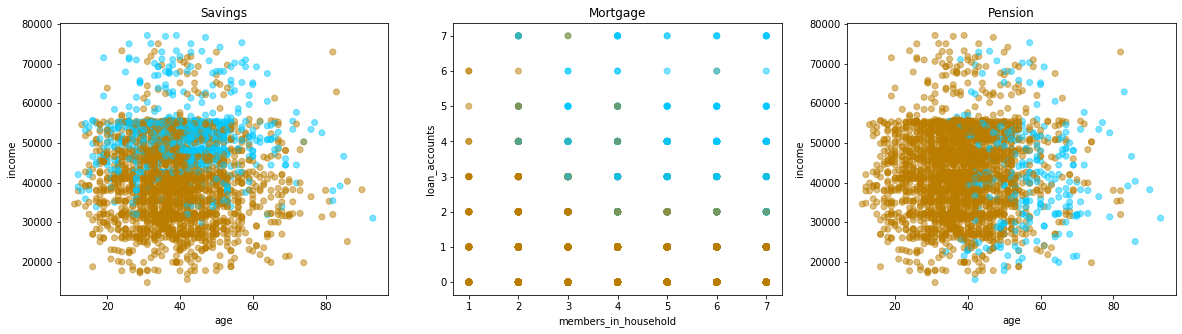

In [20]:
plot_cloud_points(offers)

The predicted data has the same semantic as the base data, with even more clear frontiers:
* for savings, there is a  clear frontier at $50K revenue.
* for pension, there is a clear frontier at 55 years old customers.

The training data contains customers who bought more than one product, let's see our prediction

In [21]:
a = offers[offers.Mortgage == 1]
b = offers[offers.Pension == 1]
c = offers[offers.Savings == 1]
print("Number of new customers: %d" %len(offers))
print("Number of customers predicted to buy mortgages: %d" %len(a))
print("Number of customers predicted to buy pensions: %d" %len(b))
print("Number of customers predicted to buy savings: %d" %len(c))

Number of new customers: 2756
Number of customers predicted to buy mortgages: 392
Number of customers predicted to buy pensions: 284
Number of customers predicted to buy savings: 750


In [22]:
to_predict["nb_products"] = to_predict.Mortgage + to_predict.Pension + to_predict.Savings

abc = to_predict[to_predict.nb_products > 1]
print("It's predicted that %d clients would buy more than one product" %len(abc))
abc = to_predict[to_predict.nb_products == 3]
print("It's predicted that %d clients would buy all three products" %len(abc))

It's predicted that 204 clients would buy more than one product
It's predicted that 7 clients would buy all three products


In [23]:
unknown_behaviors['Mortgage'] = offers.Mortgage
unknown_behaviors['Pension'] = offers.Pension
unknown_behaviors['Savings'] = offers.Savings

## Remarks on the prediction
The goal is to contact the customers to sell them only one product, so you cannot select all of them.
This increases the complexity of the problem: you need to determine the best contact channel, but also need to select which product will be sold to a given customer.  
It might be hard to compute this. In order to check, you will use greedy optimization algorithm

In [24]:
offers.reset_index(inplace=True)

# Get business decisions for the 2021 data. Greedy Optimization algorithm
## Assign campaigns to customers. 

* You have a prediction of who will buy what in the list of new customers.
* However, you do not have the budget to contact all of them. You have various contact channels with different costs and effectiveness.
* Furthermore, if you contact a customer you want to propose only one product per customer.

#### Using a greedy algorithm
Here is a custom algorithm that ensures 30% of offers are made per channel by choosing the most promising per channel. The algorithm then continues to add offers until the budget is reached.


In [25]:
import numpy as np
import pandas as pd
import math
from tqdm.auto import tqdm

So, this is how offer predictions look like for each customer. Base on this date I’m going to implement Greedy algorithm, which allows me to distribute marketing channels (Gifts, Newsletter, Seminar) equally and most effective within the budget limit.

In [26]:
pr_min = 0.3
df = offers[['Savings','Mortgage', 'Pension']]
df.index = offers.id
df

,Savings,Mortgage,Pension
id,,,
44256,1,0,0
46883,0,0,0
32387,0,0,0
25504,0,0,0
35979,0,1,0
...,...,...,...
40719,0,0,0
27706,0,0,0
104380,1,0,0


### Some input data:

Each product gives revenue:
* Mortgage - 200
* Pension - 300

* Savings - 400

Each channel (marketing action) costs with following success factor:
* gift - 20 / 0.20
* newslette - 15, / 0.05
* seminar - 23.0 / 0.30

Running greedy algorithm first of all I will use most effective marketing channels and move forward to less effective in ours case I will all all Seminars with the highest success factor and implement it to Savings product with the highest revenue (400) and finish with gifts implemented to Mortgage. Then I will iterate till the budget’s finished. This is how it works. 

In [27]:
# How much revenue is earned when selling each product
prod_ben = np.array([200, 300, 400])
# For each channel, cost of making a marketing action and success factor
chn = np.array([[20, .2],
                [15, 0.05],
                [23, .3]])

Let's devide clients by channels within the budget. And don't forget, that we can make only one offer to one clietn:

In [28]:
def g_opt(budg_lim):
    for i in range(3):
        budg = sum(np.sum(df*chn[i,0]))
        inc = sum(np.sum(df*prod_ben*chn[i,1]))
    total_offers = math.floor(budg_lim / (chn[1,0] * pr_min + chn[2,0] * pr_min + chn[1,0] * (1- pr_min)))
    if total_offers < sum(np.sum(df)):
        tl_m = math.floor(total_offers*pr_min)
        tl_p = math.floor(total_offers*pr_min)
        tl_s = total_offers - tl_m - tl_p
    else:
        tl_m = sum(np.sum(df) * pr_min)
        tl_p = sum(np.sum(df) * pr_min)
        tl_s = sum(np.sum(df)) - tl_m - tl_p
    totals = [tl_m, tl_p, tl_s]
    chn_sr = chn[chn[:,1].argsort()]
    cur_cost = chn_sr[-1,0]
    cur_ben = prod_ben[-1]
    cur_prob = chn_sr[-1,1]
    tot_budg = 0
    df_cost = df.copy()
    df_prob = df.copy()
    df_ben = df.copy()
    out_of_budget = False
    counter = 0
    step = -1

    for j in [2, 1, 0]:
        for i in range(len(df)):

            if tot_budg > budg_lim:
                tot_budg -= cur_cost
                out_of_budget = True
                break
            if out_of_budget: break
            if df.iloc[i, j] != 0:
                counter += 1
                tot_budg += cur_cost
            if counter > totals[step]:
                counter = 0
                step = step - 1
                if step == -4:
                    out_of_budget = True
                    break
                if out_of_budget: break
                cur_cost = chn_sr[step, 0]
                cur_prob = chn_sr[step, 1]
                cur_ben = prod_ben[step]
            df_cost.iloc[i,j] = df.iloc[i,j]*cur_cost
            df_ben.iloc[i, j] = df.iloc[i, j] * cur_ben
            df_prob.iloc[i, j] = df.iloc[i, j] * cur_prob

    df_cost = df_cost.replace(1,0)
    df_ben = df_ben.replace(1,0)
    df_prob = df_prob.replace(1,0)

    return tl_m, tl_p, tl_s, sum(np.sum(df_cost)), sum(np.sum(df_ben*df_prob.values))

Optimization result for $20000 budget:

In [29]:
budg = 20000
print('Budget:', budg)
print('Total offers:{}'.format(sum(g_opt(budg)[0:2])))
print('Number of Mortgage offers:{}, Number of Pension offers:{}, Number of Savings offers:{}'.format(g_opt(budg)[0],
                                                                                                      g_opt(budg)[1],
                                                                                                      g_opt(budg)[2]))
print('Campaign cost:', g_opt(budg)[3])
print('Revenue:', g_opt(budg)[4])

Budget: 20000
Total offers:546
Number of Mortgage offers:273, Number of Pension offers:273, Number of Savings offers:367
Campaign cost: 18031.0
Revenue: 63220.0


Now, let’s calculate each revenue against marketing campaign cost (budget) and analyze it effectiveness. Let me remind you, that only one offer can be done to the potential client to avoid getting them angry.

In [30]:
df_optimization = pd.DataFrame(columns=['Mortgage', 'Pension', 'Savings', 'Budget','Revenue'])
budgets = list(range(5000, 46000, 2000))
for n, budg in tqdm(enumerate(budgets), total=len(budgets)):
    sr = pd.Series(g_opt(budg), index = ['Mortgage', 'Pension', 'Savings', 'Budget','Revenue'])
    df_optimization = df_optimization.append(sr, ignore_index=True)
     

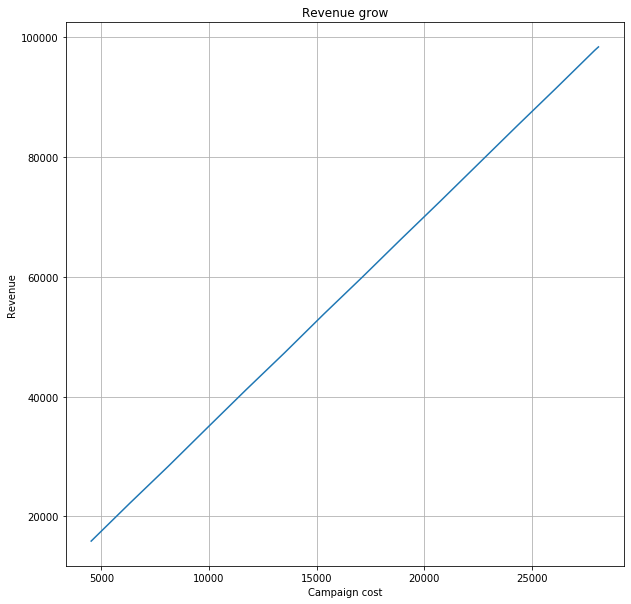

In [31]:
figure = plt.figure(figsize=(10, 10))
plt.plot(df_optimization['Budget'], df_optimization['Revenue'],)
plt.title('Revenue grow')
plt.xlabel('Campaign cost')
plt.ylabel('Revenue')
plt.grid()

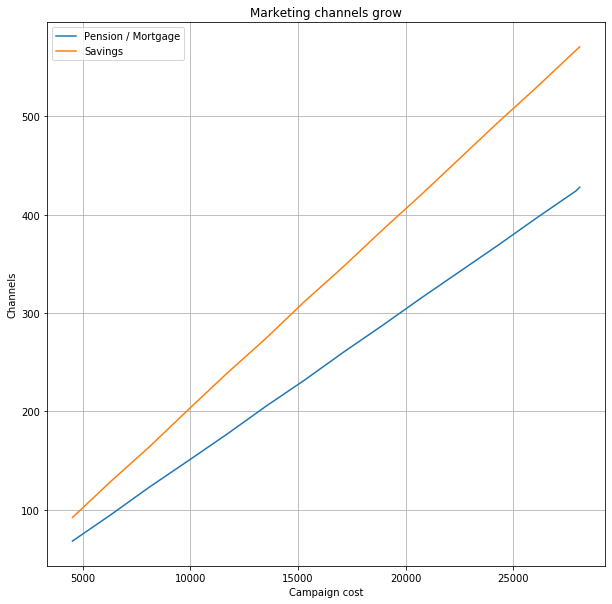

In [32]:
figure = plt.figure(figsize=(10, 10))
plt.plot(df_optimization['Budget'], df_optimization['Pension'], label='Pension / Mortgage')
plt.plot(df_optimization['Budget'], df_optimization['Savings'], label='Savings')
plt.title('Marketing channels grow')
plt.xlabel('Campaign cost')
plt.ylabel('Channels')
plt.legend()
plt.grid()

Summarizing  file:

In [33]:
df_optimization.to_excel('optimization.xlsx', index=False)
df_optimization

,Mortgage,Pension,Savings,Budget,Revenue
0,68.0,68.0,92.0,4531.0,15870.0
1,95.0,95.0,129.0,6327.0,22200.0
2,123.0,123.0,164.0,8112.0,28360.0
3,150.0,150.0,202.0,9931.0,34810.0
4,177.0,177.0,239.0,11727.0,41140.0
5,205.0,205.0,274.0,13512.0,47300.0
6,232.0,232.0,312.0,15331.0,53750.0
7,260.0,260.0,347.0,17116.0,59910.0
8,287.0,287.0,384.0,18912.0,66240.0
9,315.0,315.0,420.0,20720.0,72520.0


It’s clear, that Revenue has linear dependency against campaign cost. The same happens with offer quantity – it’s getting higher if the cost grows.  

Also we can note, that Revenue stops growing after the cost reaches **28090**. It means that we reached all possible offers can made as per the prediction model. **28090** will be the real budget limit with Revenue **$98360** accordingly because we are not allowed to make more offers than one to one customer 

# New customer clusterization

Clusterization is an unsupervised clustering / topic extraction. We have no previous knowledge on the number of topics there are in every corpus of documents.

A conventional approach involves an -optional- initial step of LSA (Latent Semantic Analysis) (TruncatedSVD) for dimensionalty reduction followed by K-Means. The downside to this approach in this scenario is that it requires a predefined number of clusters, which is not available

If a good candidate for k is found K-Means can be re-run using it as input. In addition, several K-Means runs are advised since the algorithm might end up in a local optima.


SVD/LSA
TruncatedSVD implements a variant of singular value decomposition (SVD) that only computes the k largest singular values, where k is a user-specified parameter.

When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as latent semantic analysis (LSA), because it transforms such matrices to a “semantic” space of low dimensionality.

In particular, LSA is known to combat the effects of synonymy and polysemy (both of which roughly mean there are multiple meanings per word), which cause term-document matrices to be overly sparse and exhibit poor similarity under measures such as cosine similarity.

After a couple of experiments I decided to take 4 clusters as the most optimal.

In [34]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [35]:
def plot(x,y,cl):
    plt.figure(figsize=(10,10))
    for i in range(len(Y)):
        if cl[i] == 0: clr = 'blue'
        if cl[i] == 1: clr = 'green'
        if cl[i] == 2: clr = 'red'
        if cl[i] == 3: clr = 'black'
        #if cl[i] == 4: clr = 'yellow'
        #if cl[i] == 5: clr = 'pink'
        plt.scatter(feat[i, 0], feat[i, 1], c=clr)
    plt.show()

Let's run it through the TruncatedSVD and Kmeans algorithm and plot it on the scatter plot:

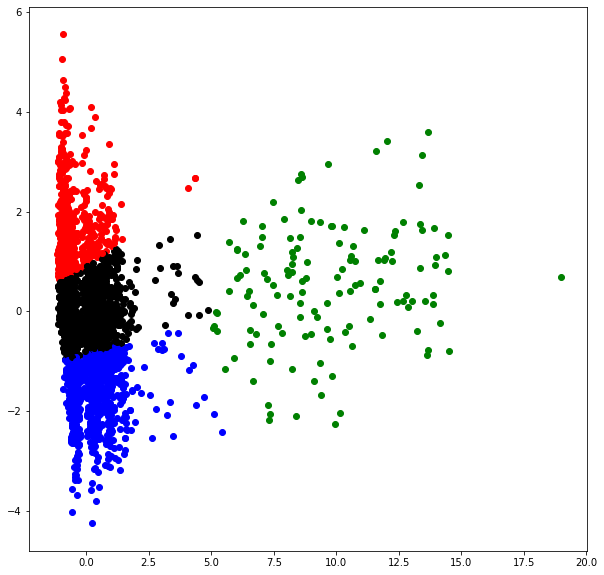

In [36]:
df = unknown_behaviors
Y = np.array(df[['Mortgage', 'Pension', 'Savings']])
x = np.array(df.drop(columns=['Mortgage', 'Pension', 'Savings']))
scaler = preprocessing.RobustScaler().fit(x)
X_train_transformed = scaler.transform(x)
model = KMeans(n_clusters=4, random_state=0)
svd = TruncatedSVD(n_components=2, random_state=0)
feat = svd.fit_transform(X_train_transformed)
pred = model.fit_predict(feat)
plot(feat, Y, pred)

In [37]:
unknown_behaviors['Cluster'] = pred
unknown_behaviors.to_excel('unknown_behaviors_pred.xlsx', index=False)
unknown_behaviors

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,...,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage,Pension,Savings,Cluster
0,44256,38,11,38,1,0,0,0,58,47958.0,...,1,2,1,9,31,7.949,0,0,1,0
1,46883,30,1,30,0,0,0,0,55,48606.0,...,4,3,2,11,33,11.437,0,0,0,0
2,32387,41,13,41,1,0,0,0,59,42152.0,...,0,1,1,11,29,7.462,0,0,0,0
3,25504,42,14,42,1,0,0,0,57,39788.0,...,3,0,0,15,27,0.000,0,0,0,3
4,35979,42,14,42,1,0,0,0,53,44365.0,...,2,3,1,5,41,7.806,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,40719,63,37,63,0,0,0,0,39,46462.0,...,0,2,1,12,48,11.317,0,0,0,3
2752,27706,42,12,42,1,0,0,0,42,40860.0,...,3,0,0,21,35,0.000,0,0,0,2
2753,104380,58,29,58,0,0,0,0,57,70944.0,...,0,1,1,8,33,9.126,0,0,1,2
2754,23228,69,41,69,0,0,0,0,60,38196.0,...,1,0,0,12,27,0.000,0,0,0,2


This is how clusters look like against customer income and age (Household Debt to Equity Ratio, Members In Household, Loan Accounts)

Text(0.5, 0, 'Income')

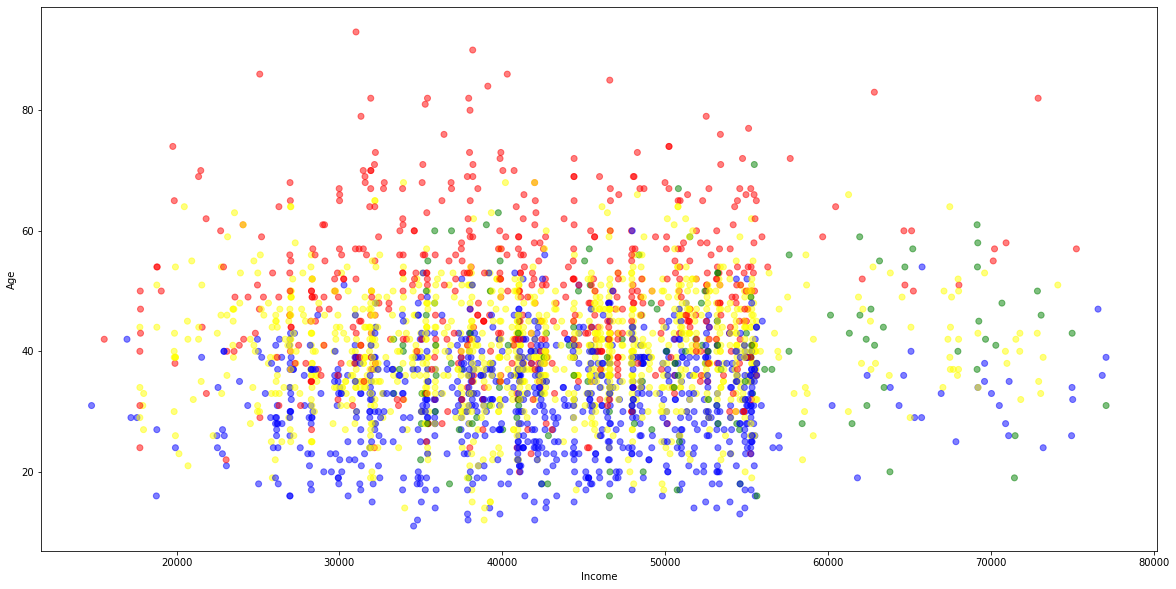

In [38]:
figure = plt.figure(figsize=(20, 10))
my_cm  = ListedColormap(['blue', 'green', 'red', 'yellow'])
plt.scatter(unknown_behaviors['income'], unknown_behaviors['age'], c=unknown_behaviors['Cluster'], cmap=my_cm, alpha=0.5)
plt.ylabel('Age')
plt.xlabel('Income')

Text(0.5, 0, 'Income')

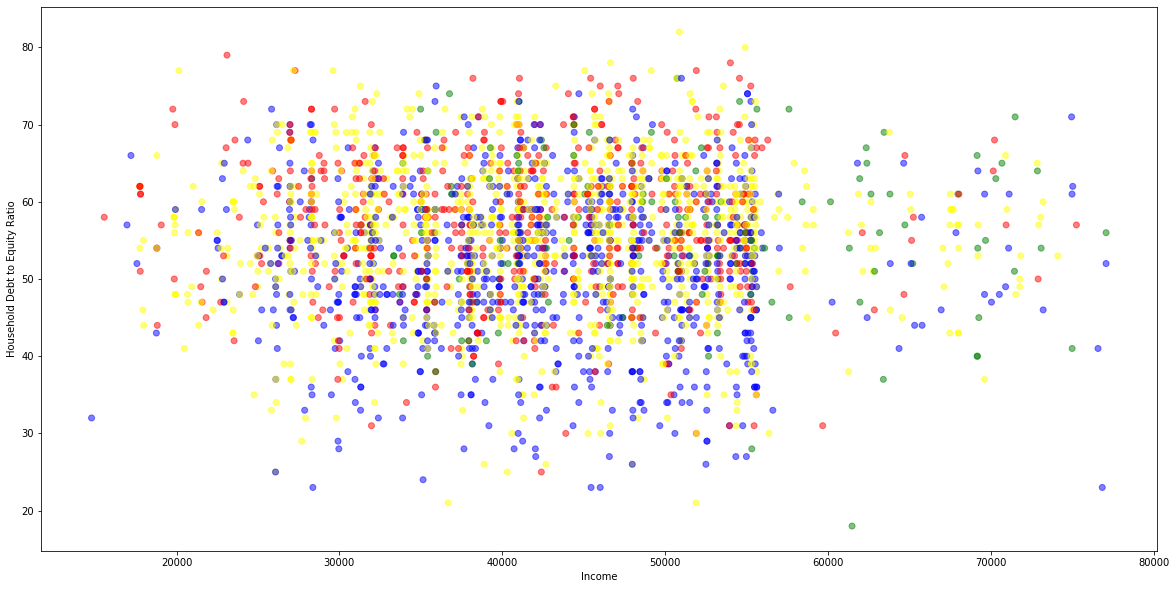

In [39]:
figure = plt.figure(figsize=(20, 10))
my_cm  = ListedColormap(['blue', 'green', 'red', 'yellow'])
plt.scatter(unknown_behaviors['income'], unknown_behaviors['household_debt_to_equity_ratio'], c=unknown_behaviors['Cluster'], cmap=my_cm, alpha=0.5)
plt.ylabel('Household Debt to Equity Ratio')
plt.xlabel('Income')

Text(0.5, 0, 'Income')

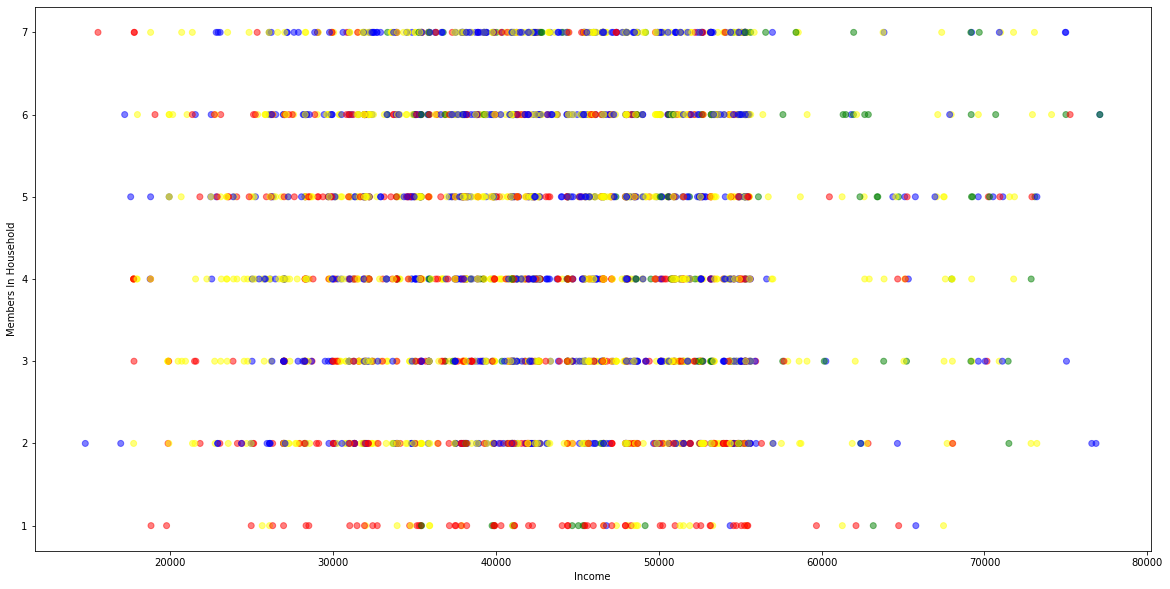

In [40]:
figure = plt.figure(figsize=(20, 10))
my_cm  = ListedColormap(['blue', 'green', 'red', 'yellow'])
plt.scatter(unknown_behaviors['income'], unknown_behaviors['members_in_household'], c=unknown_behaviors['Cluster'], cmap=my_cm, alpha=0.5)
plt.ylabel('Members In Household')
plt.xlabel('Income')

Text(0.5, 0, 'Income')

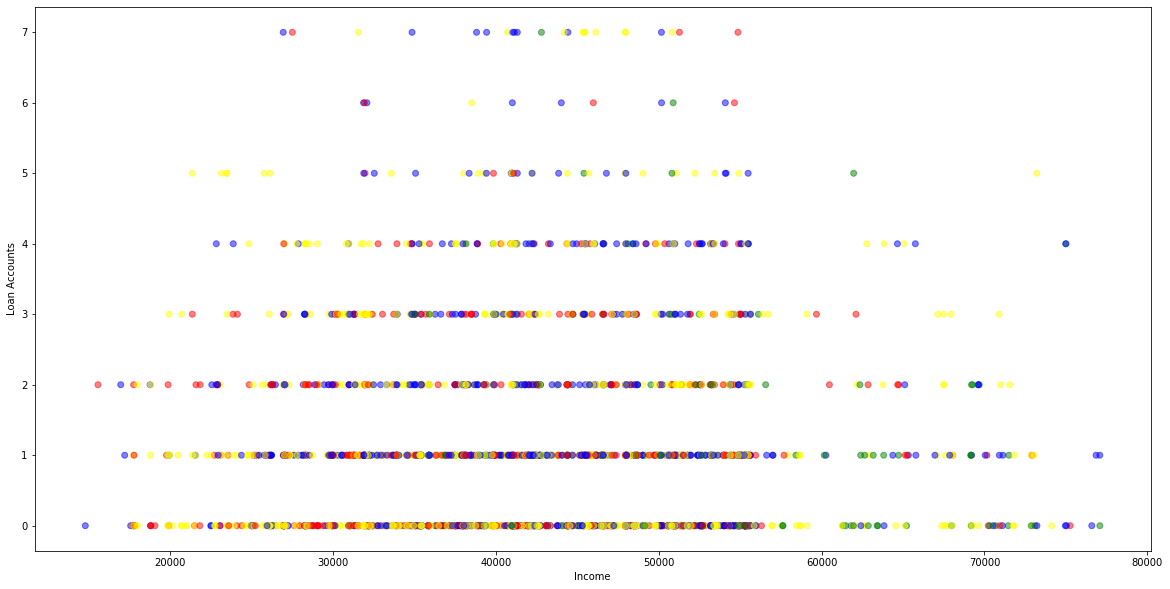

In [41]:
figure = plt.figure(figsize=(20, 10))
my_cm  = ListedColormap(['blue', 'green', 'red', 'yellow'])
plt.scatter(unknown_behaviors['income'], 
            unknown_behaviors['loan_accounts'], 
            c=unknown_behaviors['Cluster'], 
            cmap=my_cm, 
            alpha=0.5)
plt.ylabel('Loan Accounts')
plt.xlabel('Income')

# Summary conclusion 

This notebook implemented 3 models to optimize further marketing campaign and shows clear picture how and what we will do within budget limits. Models give us a range options for further steps and simplify decision making.
Considering 2756 possible new customers prediction model give us such results:

-	Number of customers predicted to buy mortgages: 392
-	Number of customers predicted to buy pensions: 284
-	Number of customers predicted to buy savings: 750
-	It's predicted that 204 clients would buy more than one product
-	It's predicted that 7 clients would buy all three products

If the budget limit will be 20000:

-	Total offers: 546
-	Number of Mortgage offers: 273, Number of Pension offers: 273, Number of Savings offers: 367
-	Campaign cost: 18031.0
-	Revenue: 63220.0

And clusterization model dividing all possible onto 4 clusters will help to marketing department arrange offering process in the best way as possible 


[Jump to Content](#Content)